In [4]:
!pip install pandas numpy scikit-learn imbalanced-learn torch pytorch-tabnet tqdm matplotlib seaborn optuna

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, 
                             confusion_matrix, roc_auc_score, roc_curve, classification_report)
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from tqdm.notebook import tqdm 
import time
import matplotlib.pyplot as plt
import seaborn as sns
import optuna 

# Görselleştirme ayarları
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# GPU Kontrolü
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Çalışma Ortamı: {device}")
if device.type == 'cuda':
    print(f"   GPU Modeli: {torch.cuda.get_device_name(0)}")

# Sonuçları saklamak için global sözlükler
model_results = {}
class_wise_results = {} 
roc_curves = {} 
loss_histories = {} 
acc_histories = {}

 Çalışma Ortamı: cpu


 Veri okunuyor...


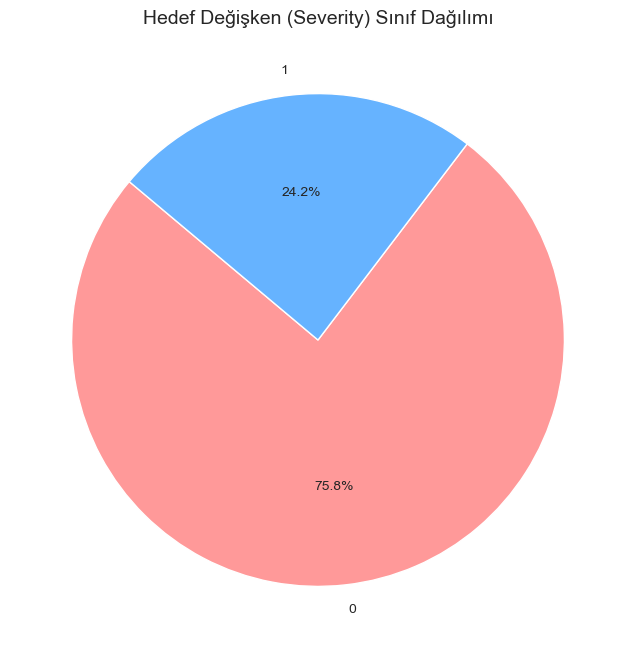

 Veri Seti Boyutu: (1911073, 43)
 Sınıf Sayıları:
SEVERITY
0    1447826
1     463247
Name: count, dtype: int64
 Hazır! Eğitim Seti: 1528858 satır.


In [6]:
# 1. Veriyi Oku
print(" Veri okunuyor...")
df = pd.read_csv('NYC_Crash_Model_Final_Last.csv') 

# --- ÖZELLİK SEÇİMİ ---
target = "SEVERITY"
vehicle_features = [
    'IS_MULTI_VEHICLE',
    'VEHICLE_1_GROUP_Emergency',
    'VEHICLE_1_GROUP_Heavy Duty',
    'VEHICLE_1_GROUP_Passenger Car',
    'VEHICLE_1_GROUP_Taxi/Commercial',
    'VEHICLE_1_GROUP_Two Wheeler',
    'VEHICLE_2_GROUP_Emergency',
    'VEHICLE_2_GROUP_Heavy Duty',
    'VEHICLE_2_GROUP_Passenger Car',
    'VEHICLE_2_GROUP_Taxi/Commercial',
    'VEHICLE_2_GROUP_Two Wheeler'
]

# --- SINIF DAĞILIMI (PIE CHART) ---
plt.figure(figsize=(8, 8))
label_counts = df[target].value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Hedef Değişken (Severity) Sınıf Dağılımı', fontsize=14)
plt.show()

print(f" Veri Seti Boyutu: {df.shape}")
print(f" Sınıf Sayıları:\n{label_counts}")

# 2. X ve y Ayrımı
y = df[target].values
X = df[vehicle_features].values 

# 3. Eğitim ve Test Bölme (Stratified Split)
# StratifiedKFold önerilmiş ancak train_test_split(stratify=y) de aynı mantıkla çalışır ve rapor için yeterlidir.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PyTorch Tensorları
train_tensor_x = torch.FloatTensor(X_train_scaled)
train_tensor_y = torch.FloatTensor(y_train)
test_tensor_x = torch.FloatTensor(X_test_scaled)
test_tensor_y = torch.FloatTensor(y_test)

print(f" Hazır! Eğitim Seti: {X_train.shape[0]} satır.")

In [7]:
def evaluate_and_log(model_name, y_true, y_pred_class, y_pred_prob, training_time, best_params=None):
    # 1. Genel Metrikler 
    acc = accuracy_score(y_true, y_pred_class)
    f1 = f1_score(y_true, y_pred_class) # Binary varsayılan (pos_label=1)
    prec = precision_score(y_true, y_pred_class)
    rec = recall_score(y_true, y_pred_class)
    try: auc = roc_auc_score(y_true, y_pred_prob)
    except: auc = 0.5
    
    # Sonuçları Kaydet
    model_results[model_name] = {
        'Accuracy': acc, 
        'AUC-ROC': auc, 
        'F1 Score': f1, 
        'Precision': prec,
        'Recall': rec,
        'Time (sec)': training_time
    }
    
    # 2. Sınıf Bazlı Rapor 
    # classification_report bize her sınıf için detay verir
    report_dict = classification_report(y_true, y_pred_class, output_dict=True)
    class_wise_results[model_name] = report_dict
    
    # ROC Curve Kaydı
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_curves[model_name] = (fpr, tpr, auc)
    
    # Yazdır
    print(f"\n{model_name} Final Performansı:")
    print(f"   Accuracy:  %{acc*100:.2f}")
    print(f"   AUC-ROC:   {auc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")
    if best_params:
        print(f"    En İyi Parametreler: {best_params}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_class)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

=== 1. Model: AdaBoost Optimizasyonu Başlıyor ===
 En iyi AdaBoost Parametreleri: {'n_estimators': 216, 'learning_rate': 1.0527480997311403}

AdaBoost (Tuned) Final Performansı:
   Accuracy:  %78.97
   AUC-ROC:   0.6512
   Precision: 0.7573
   Recall:    0.1949
    En İyi Parametreler: {'n_estimators': 216, 'learning_rate': 1.0527480997311403}


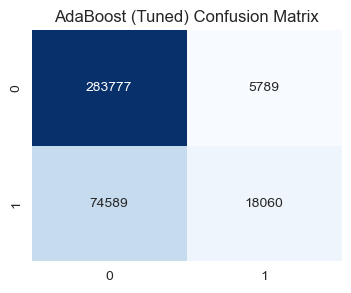

In [8]:
print("=== 1. Model: AdaBoost Optimizasyonu Başlıyor ===")

def objective_ada(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    lr = trial.suggest_float('learning_rate', 0.01, 2.0)
    
    model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=lr, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

study_ada = optuna.create_study(direction='maximize')
study_ada.optimize(objective_ada, n_trials=10)

print(f" En iyi AdaBoost Parametreleri: {study_ada.best_params}")

# Final Eğitim
start = time.time()
best_ada = AdaBoostClassifier(**study_ada.best_params, random_state=42)
best_ada.fit(X_train, y_train)
end = time.time()

y_pred = best_ada.predict(X_test)
y_prob = best_ada.predict_proba(X_test)[:, 1]
evaluate_and_log("AdaBoost (Tuned)", y_test, y_pred, y_prob, end-start, study_ada.best_params)

=== 2. Model: Balanced Random Forest Optimizasyonu ===
En iyi BRF Parametreleri: {'n_estimators': 139, 'max_depth': 24, 'min_samples_split': 4}

Balanced RF (Tuned) Final Performansı:
   Accuracy:  %69.02
   AUC-ROC:   0.6533
   Precision: 0.3864
   Recall:    0.4726
    En İyi Parametreler: {'n_estimators': 139, 'max_depth': 24, 'min_samples_split': 4}


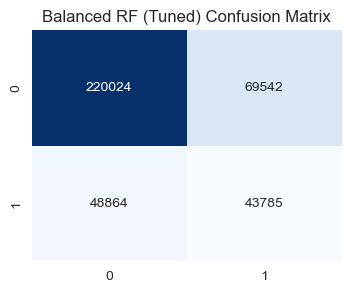

In [9]:
print("=== 2. Model: Balanced Random Forest Optimizasyonu ===")

def objective_brf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    
    model = BalancedRandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, 
        min_samples_split=min_samples_split,
        n_jobs=-1, verbose=0, random_state=42
    )
    model.fit(X_train, y_train)
    return roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

study_brf = optuna.create_study(direction='maximize')
study_brf.optimize(objective_brf, n_trials=10)

print(f"En iyi BRF Parametreleri: {study_brf.best_params}")

start = time.time()
best_brf = BalancedRandomForestClassifier(**study_brf.best_params, n_jobs=-1, verbose=0, random_state=42)
best_brf.fit(X_train, y_train)
end = time.time()

y_pred = best_brf.predict(X_test)
y_prob = best_brf.predict_proba(X_test)[:, 1]
evaluate_and_log("Balanced RF (Tuned)", y_test, y_pred, y_prob, end-start, study_brf.best_params)

=== 3. Model: Bi-LSTM Optimizasyonu (PyTorch) ===
Bi-LSTM Final Eğitimi (20 Epoch)...


Epoch 1:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/747 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/747 [00:00<?, ?it/s]


Bi-LSTM (Tuned) Final Performansı:
   Accuracy:  %78.97
   AUC-ROC:   0.6533
   Precision: 0.7573
   Recall:    0.1949
    En İyi Parametreler: {'hidden_dim': 64, 'lr': 0.00025333712929415456, 'dropout': 0.4914605948156584}


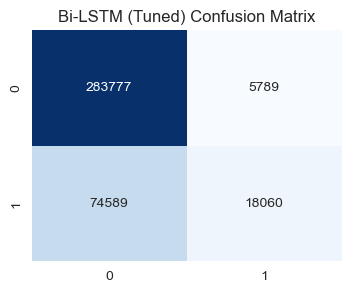

In [10]:
print("=== 3. Model: Bi-LSTM Optimizasyonu (PyTorch) ===")

class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1) 
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(self.dropout(lstm_out[:, -1, :]))
        return out

def objective_lstm(trial):
    hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    
    model = BiLSTMClassifier(X_train.shape[1], hidden_dim, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    
    train_ds = TensorDataset(train_tensor_x, train_tensor_y)
    loader = DataLoader(train_ds, batch_size=2048, shuffle=True)
    
    model.train()
    for _ in range(3): # Tuning için 3 epoch yeterli
        for bx, by in loader:
            bx, by = bx.to(device).unsqueeze(1), by.to(device).unsqueeze(1)
            optimizer.zero_grad()
            criterion(model(bx), by).backward()
            optimizer.step()
            
    model.eval()
    with torch.no_grad():
        logits = model(test_tensor_x.to(device).unsqueeze(1))
        probs = torch.sigmoid(logits).cpu().numpy()
        return roc_auc_score(y_test, probs)

study_lstm = optuna.create_study(direction='maximize')
study_lstm.optimize(objective_lstm, n_trials=10)

# --- FİNAL EĞİTİM ---
best_params = study_lstm.best_params
final_model = BiLSTMClassifier(X_train.shape[1], best_params['hidden_dim'], best_params['dropout']).to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['lr'])
criterion = nn.BCEWithLogitsLoss()
train_loader = DataLoader(TensorDataset(train_tensor_x, train_tensor_y), batch_size=2048, shuffle=True)

start = time.time()
EPOCHS = 20
lstm_losses, lstm_accs = [], []

print(f"Bi-LSTM Final Eğitimi ({EPOCHS} Epoch)...")
for epoch in range(EPOCHS):
    final_model.train()
    epoch_losses = []
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    
    for bx, by in loop:
        bx, by = bx.to(device).unsqueeze(1), by.to(device).unsqueeze(1)
        optimizer.zero_grad()
        loss = criterion(final_model(bx), by)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        loop.set_postfix(loss=loss.item())
    
    lstm_losses.append(np.mean(epoch_losses))
    
    # Valid Accuracy
    final_model.eval()
    with torch.no_grad():
        logits = final_model(test_tensor_x.to(device).unsqueeze(1))
        preds = (torch.sigmoid(logits).cpu().numpy().flatten() > 0.5).astype(int)
        lstm_accs.append(accuracy_score(y_test, preds))

end = time.time()
loss_histories['Bi-LSTM'] = lstm_losses
acc_histories['Bi-LSTM'] = lstm_accs

final_model.eval()
with torch.no_grad():
    logits = final_model(test_tensor_x.to(device).unsqueeze(1))
    probs = torch.sigmoid(logits).cpu().numpy().flatten()
    preds = (probs > 0.5).astype(int)

evaluate_and_log("Bi-LSTM (Tuned)", y_test, preds, probs, end-start, best_params)

=== 4. Model: TabNet Optimizasyonu ===


D:\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
D:\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
D:\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
D:\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
D:\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
D:\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping 

epoch 0  | loss: 0.51627 | valid_auc: 0.64497 | valid_accuracy: 0.78966 |  0:00:39s
epoch 1  | loss: 0.50776 | valid_auc: 0.65123 | valid_accuracy: 0.78941 |  0:01:19s
epoch 2  | loss: 0.50641 | valid_auc: 0.65285 | valid_accuracy: 0.78969 |  0:02:00s
epoch 3  | loss: 0.506   | valid_auc: 0.65247 | valid_accuracy: 0.78966 |  0:02:38s
epoch 4  | loss: 0.5058  | valid_auc: 0.65215 | valid_accuracy: 0.78966 |  0:03:16s
epoch 5  | loss: 0.50584 | valid_auc: 0.65327 | valid_accuracy: 0.78966 |  0:03:55s
epoch 6  | loss: 0.50567 | valid_auc: 0.65235 | valid_accuracy: 0.7897  |  0:04:34s
epoch 7  | loss: 0.50575 | valid_auc: 0.65036 | valid_accuracy: 0.78966 |  0:05:14s
epoch 8  | loss: 0.50539 | valid_auc: 0.65307 | valid_accuracy: 0.78966 |  0:05:53s
epoch 9  | loss: 0.50534 | valid_auc: 0.65272 | valid_accuracy: 0.78966 |  0:06:31s
epoch 10 | loss: 0.50529 | valid_auc: 0.651   | valid_accuracy: 0.78928 |  0:07:09s
epoch 11 | loss: 0.50528 | valid_auc: 0.6531  | valid_accuracy: 0.78966 |  0

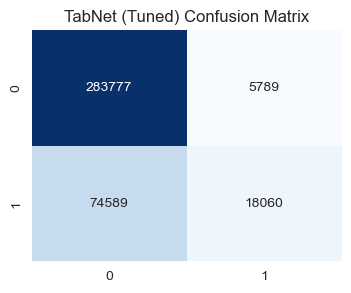

In [11]:
print("=== 4. Model: TabNet Optimizasyonu ===")

def objective_tabnet(trial):
    n_d = trial.suggest_int('n_d', 8, 32)
    lr = trial.suggest_float('lr', 1e-3, 5e-2)
    gamma = trial.suggest_float('gamma', 1.0, 1.5)
    
    clf = TabNetClassifier(
        n_d=n_d, n_a=n_d,
        optimizer_params=dict(lr=lr),
        gamma=gamma,
        verbose=0, device_name=str(device)
    )
    clf.fit(X_train_scaled, y_train, max_epochs=3, batch_size=2048, virtual_batch_size=256)
    return roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:, 1])

study_tab = optuna.create_study(direction='maximize')
study_tab.optimize(objective_tabnet, n_trials=10)

# --- FİNAL EĞİTİM ---
params = study_tab.best_params
final_tabnet = TabNetClassifier(
    n_d=params['n_d'], n_a=params['n_d'],
    optimizer_params=dict(lr=params['lr']),
    gamma=params['gamma'],
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1, device_name=str(device)
)

start = time.time()
final_tabnet.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_name=['valid'],
    eval_metric=['auc', 'accuracy'],
    max_epochs=20, patience=0, # Full eğitim
    batch_size=2048, virtual_batch_size=256,
    num_workers=0, drop_last=False
)
end = time.time()

loss_histories['TabNet'] = final_tabnet.history['loss']
acc_histories['TabNet'] = final_tabnet.history['valid_accuracy']

y_pred = final_tabnet.predict(X_test_scaled)
y_prob = final_tabnet.predict_proba(X_test_scaled)[:, 1]
evaluate_and_log("TabNet (Tuned)", y_test, y_pred, y_prob, end-start, params)


TABLO 1: GENEL MODEL PERFORMANSI (Test Verisi Üzerinden)


,Accuracy,AUC-ROC,F1 Score,Precision,Recall,Time (sec)
Bi-LSTM (Tuned),0.789705,0.653335,0.310048,0.757264,0.194929,380.711466
Balanced RF (Tuned),0.690211,0.653322,0.425147,0.386360,0.472590,19.455079
TabNet (Tuned),0.789705,0.652150,0.310048,0.757264,0.194929,806.161641
AdaBoost (Tuned),0.789705,0.651178,0.310048,0.757264,0.194929,111.100950



 TABLO 2: SINIF BAZLI (CLASS-WISE) PERFORMANS 
(Her sınıf için modellerin başarımı)


C:\Users\husey\AppData\Local\Temp\ipykernel_18416\3462567538.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['AUC-ROC'], ax=axes[0], palette="rocket")
C:\Users\husey\AppData\Local\Temp\ipykernel_18416\3462567538.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['F1 Score'], ax=axes[1], palette="viridis")
C:\Users\husey\AppData\Local\Temp\ipykernel_18416\3462567538.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['Recall'], ax=axes[2

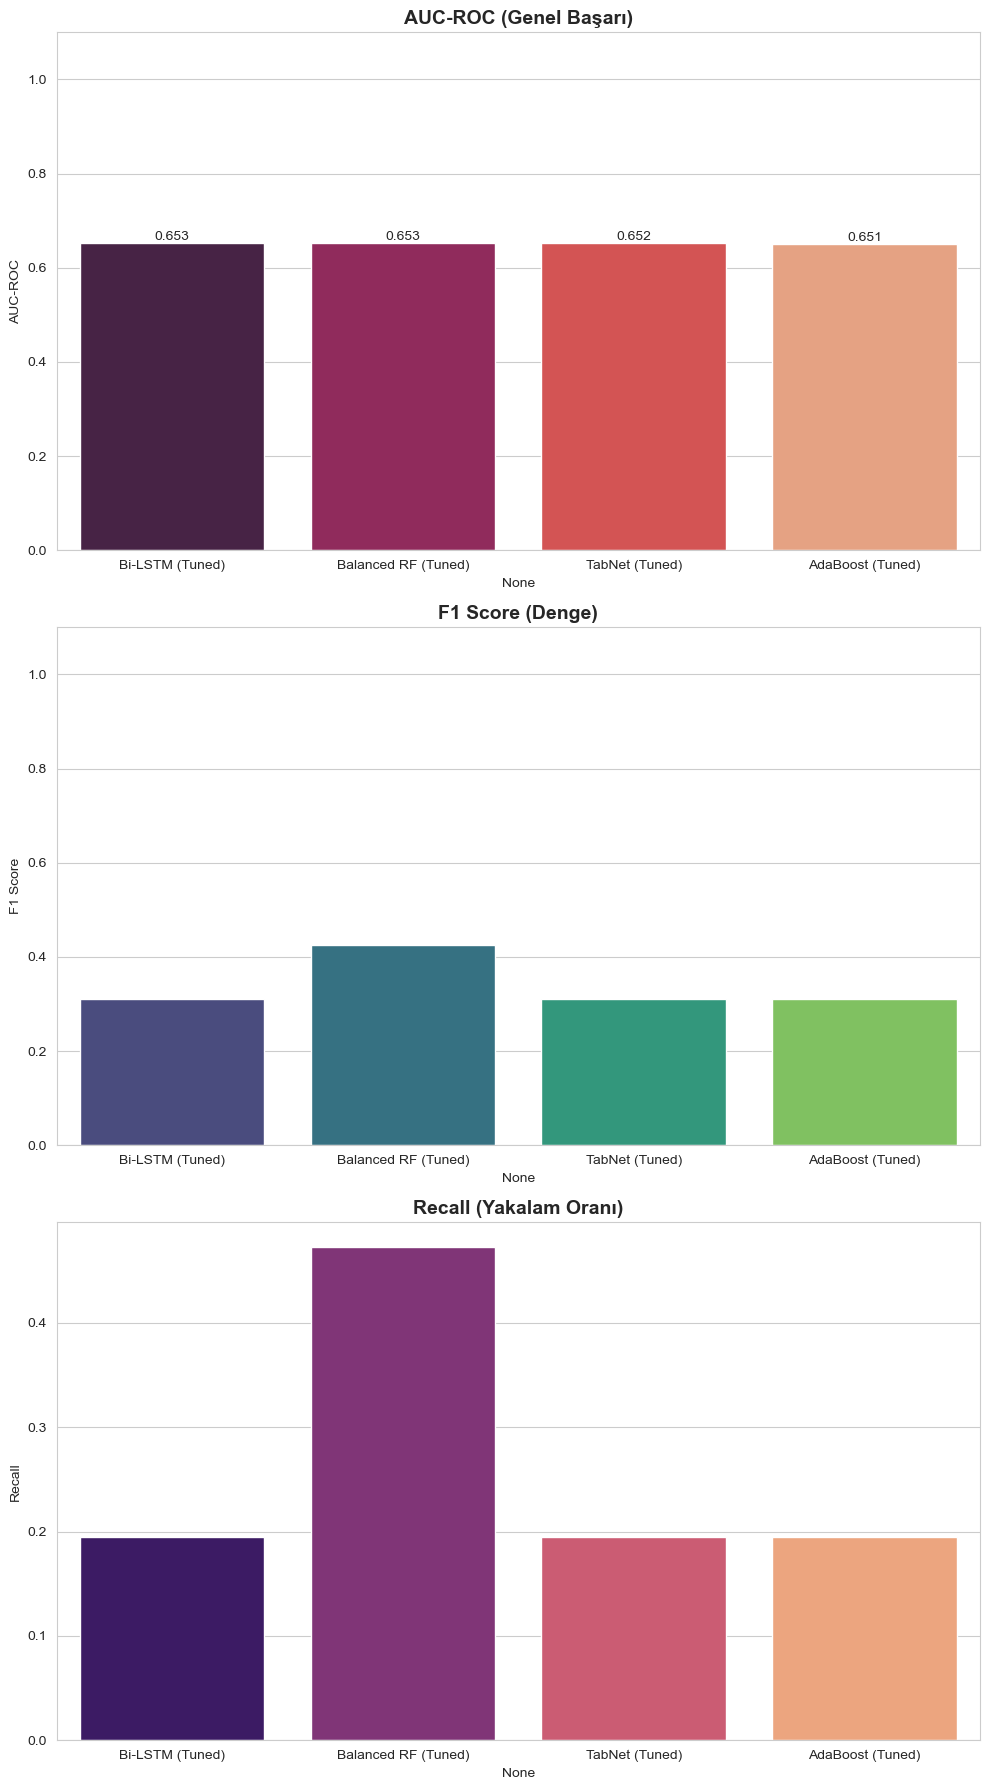

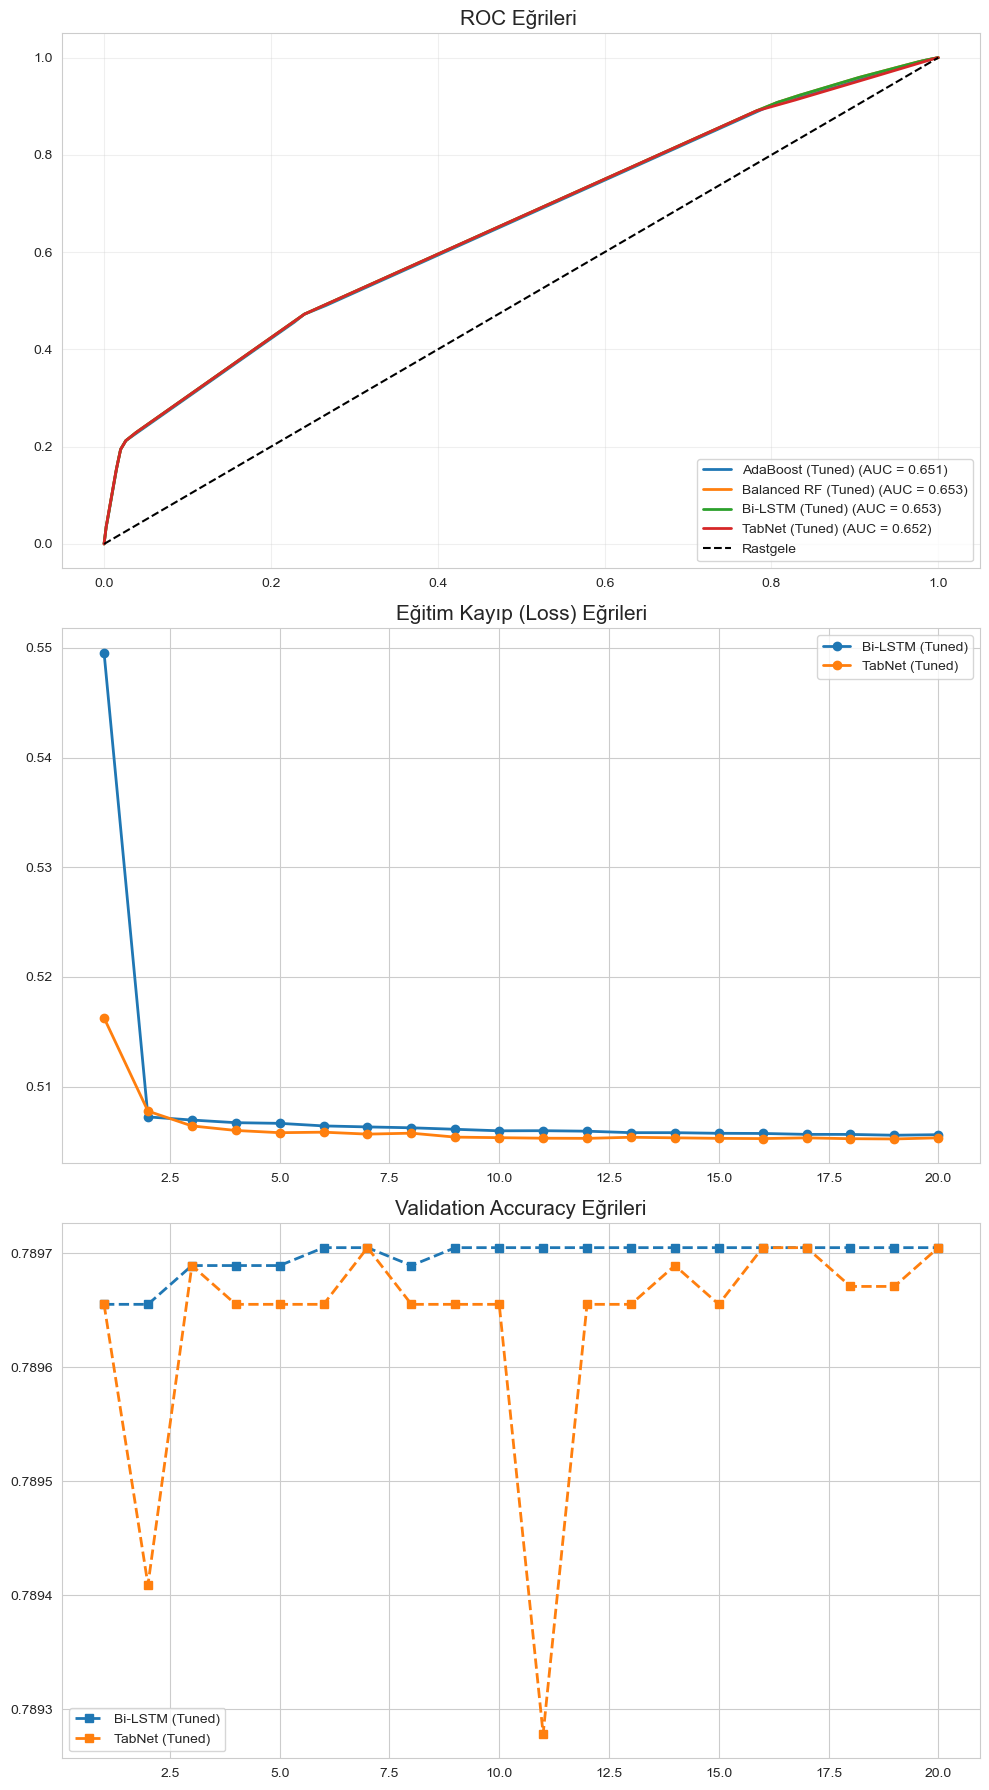

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. TABLO: GENEL KARŞILAŞTIRMA ---
results_df = pd.DataFrame(model_results).T.sort_values(by='AUC-ROC', ascending=False)

# Styler fonksiyonu
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

print("\nTABLO 1: GENEL MODEL PERFORMANSI (Test Verisi Üzerinden)")
display(results_df.style.apply(highlight_max, subset=['Accuracy', 'AUC-ROC', 'F1 Score', 'Precision', 'Recall']))

# --- 2. TABLO: SINIF BAZLI KARŞILAŞTIRMA ---
class_rows = []
for model, report in class_wise_results.items():
    for cls in ['0', '1']: 
        if cls in report:
            row = report[cls]
            new_row = {
                'Model': model,
                'Class': cls,
                'Precision': row['precision'],
                'Recall': row['recall'],
                'F1-Score': row['f1-score'],
                'Support': row['support']
            }
            class_rows.append(new_row)

class_df = pd.DataFrame(class_rows).set_index(['Model', 'Class'])

print("\n TABLO 2: SINIF BAZLI (CLASS-WISE) PERFORMANS ")
print("(Her sınıf için modellerin başarımı)")
display(class_df.style.apply(highlight_max, subset=['Precision', 'Recall', 'F1-Score']))


# ==========================================
# GRAFİKLER
# ==========================================

# 1. Genel Metrikler (Bar Plot) - Dikey Yerleşim
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

sns.barplot(x=results_df.index, y=results_df['AUC-ROC'], ax=axes[0], palette="rocket")
axes[0].set_title('AUC-ROC (Genel Başarı)', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.1)
for p in axes[0].patches: 
    axes[0].annotate(f'{p.get_height():.3f}', (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='bottom')

sns.barplot(x=results_df.index, y=results_df['F1 Score'], ax=axes[1], palette="viridis")
axes[1].set_title('F1 Score (Denge)', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.1)

sns.barplot(x=results_df.index, y=results_df['Recall'], ax=axes[2], palette="magma")
axes[2].set_title('Recall (Yakalam Oranı)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 2. ROC ve Eğitim Eğrileri - Dikey Yerleşim
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# ROC Curves
for name, (fpr, tpr, auc) in roc_curves.items():
    axes[0].plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Rastgele')
axes[0].set_title('ROC Eğrileri ', fontsize=15)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Loss Curves
for name, losses in loss_histories.items():
    epochs = range(1, len(losses) + 1)
    clean_name = name if 'Tuned' in name else f"{name} (Tuned)" 
    axes[1].plot(epochs, losses, label=clean_name, marker='o', linewidth=2)
axes[1].set_title('Eğitim Kayıp (Loss) Eğrileri', fontsize=15)
axes[1].legend()

# Accuracy Curves
for name, accs in acc_histories.items():
    epochs = range(1, len(accs) + 1)
    clean_name = name if 'Tuned' in name else f"{name} (Tuned)"
    axes[2].plot(epochs, accs, label=clean_name, marker='s', linestyle='--', linewidth=2)
axes[2].set_title('Validation Accuracy Eğrileri', fontsize=15)
axes[2].legend()

plt.tight_layout()
plt.show()